In [80]:
import mhcflurry, seaborn, numpy, pandas, pickle, sklearn, collections, scipy, time
import mhcflurry.dataset
import fancyimpute, locale
from matplotlib import pyplot


import sklearn.metrics
import sklearn.cross_validation
%matplotlib inline

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)


def print_full(x):
    pandas.set_option('display.max_rows', len(x))
    print(x)
    pandas.reset_option('display.max_rows')

In [216]:
name_adjustments = {
    "tau": "Kendall's $\\tau$",
    "auc": "AUC",
    "f1": "$F_1$ score",
    "mhcflurry ensemble all": "mhcflurry ensemble",
    "mhcflurry 0": "mhcflurry single",
    "smmpmbec_cpp": "smmpmbec cpp",
}

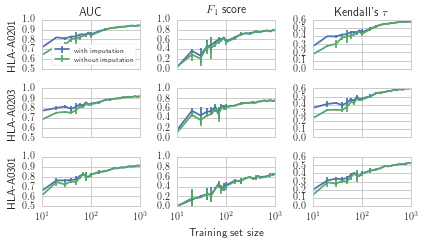

In [229]:
impute_comparison = pandas.read_csv("../data/impute_comparison.csv")

pyplot.figure(figsize=(6,3.5))
seaborn.set_style("whitegrid")

for (i, (allele, data)) in enumerate(impute_comparison.groupby("allele")):
    for (j, score) in enumerate(["test_auc", "test_f1", "test_tau"]):
        ax = pyplot.subplot2grid((3,3),(i, j)) #sharey=pyplot.gca())
        grouped = data.groupby(["train_size", "impute"])[score].mean().to_frame().reset_index()
        grouped["std_error"] = data.groupby(["train_size", "impute"])[score].std().to_frame().reset_index()[score]
        for impute in [True, False]:
            sub = grouped[grouped.impute == impute]
            pyplot.errorbar(
                           x=sub.train_size.values,
                           y=sub[score].values,
                           yerr=sub.std_error.values,
                           label=("with" if impute else "without") + " imputation",
                           color=seaborn.get_color_cycle()[0] if impute else seaborn.get_color_cycle()[1])    
        if i == 0:
            pyplot.title(name_adjustments.get(score.replace("test_", "")))
        if j == 0:
            pyplot.ylabel(allele)
        pyplot.xscale("log")
        if (i,j) == (0,0):
            pyplot.legend(loc='lower right', fancybox=True, frameon=True, fontsize="x-small")

        if (i,j) == (2,1):
            pyplot.xlabel("Training set size")
        if i != 2:
            pyplot.gca().axes.xaxis.set_ticklabels([])

        if score == "test_auc":
            pyplot.ylim(ymin=0.5, ymax=1.0)
        if score == "test_f1":
            pyplot.ylim(ymin=0, ymax=1)
        if score == "test_tau":
            pyplot.ylim(ymin=0, ymax=0.6)
            pyplot.yticks(numpy.arange(0, 0.61, 0.1))

pyplot.tight_layout()
pyplot.savefig("../figures/impute_comparison.pdf")


In [230]:
scores_df = pandas.read_csv("../data/validation_scores.csv", index_col="allele")
scores_df
big_alleles = list((scores_df.ix[(scores_df.index != "overall") & (scores_df.train_size >= 500)]).index)
small_alleles = list((scores_df.ix[(scores_df.index != "overall") & (scores_df.train_size < 500)]).index)
small_alleles

def sub_df(name):
    result = scores_df[[c for c in list(scores_df.columns) if (name + "_") in c]].copy()
    result.columns = [c.split("_")[-1] for c in list(result.columns)]
    return result

predictors = ["mhcflurry ensemble all", "mhcflurry 0", "netmhc", "netmhcpan", "smmpmbec_cpp"]

d = dict((name, sub_df(name)) for name in predictors)
panel_all = pandas.Panel(d)
panel = panel_all[predictors]
panel

def latex_table(df, max_df=None, caption=None, label=None, name_adjustments=name_adjustments):
    if max_df is None:
        max_df = df
    df_strings = df.copy()
    for col in df.columns:
        del df_strings[col]
        renamed_col = name_adjustments.get(col, col)
        df_strings[renamed_col] = [
            ("\\textbf{%s}" if x == max_df[col].max() else "%s") % (("%0.4f" % x) if isinstance(x, float) else x)
            for x in df[col]
        ]
    df_strings.index = [name_adjustments.get(x, x) for x in df_strings.index]

    print(r"\begin{table}[h]")
    print(r"\centering")
    print(df_strings.to_latex(escape=False))
    if caption:
        print("\\caption{%s}" % caption.strip())
    if label:
        print("\\label{tab:%s}" % label.strip())
    print(r"\end{table}")
    print("")

    
latex_table(panel[:,"overall"].T, label="measurementweighted",
            caption="""
            Performance on BLIND with equal weight given to each measurement ({:,d} measurements)
            """.format(scores_df.test_size.sum()))
'''
latex_table(panel.mean(1).T, label="alleleweighted",
            caption="""
            Performance on BLIND with equal weight given to each allele (%d alleles)
            """ % panel.shape[1])
latex_table(panel[:,big_alleles].mean(1).T, label="alleleweightedbig",
            caption="""
            Performance on BLIND for alleles with at least 500 training observations (%d alleles)
            """ % len(big_alleles))
#latex_table(panel[:,small_alleles].mean(1).T,
#            caption="""
#            Performance on BLIND for alleles with fewer than 500 training observations (%d alleles)
#            """ % len(small_alleles))



df=panel[:,small_alleles,"auc"]
df["train size"] = scores_df.ix[scores_df.index != 'overall'].train_size.apply(lambda x: str(int(x)))
df["test size"] = scores_df.ix[scores_df.index != 'overall'].test_size.apply(lambda x: str(int(x)))
df = df[["train size", "test size"] + list(panel.items)]
df.sort("train size", inplace=True)
latex_table(df.T, max_df = df.T.iloc[2:], label="smallalleles", caption="""
AUC scores on BLIND dataset for alleles with fewer than 500 training examples
""")
'''

\begin{table}[h]
\centering
\begin{tabular}{llll}
\toprule
{} &              AUC &      $F_1$ score & Kendall's $\tau$ \\
\midrule
mhcflurry ensemble &           0.9325 &           0.7847 &  \textbf{0.5865} \\
mhcflurry single   &           0.9313 &           0.7831 &           0.5843 \\
netmhc             &           0.9323 &  \textbf{0.8072} &           0.5863 \\
netmhcpan          &  \textbf{0.9326} &           0.7996 &           0.5814 \\
smmpmbec cpp       &           0.9213 &           0.7903 &           0.5649 \\
\bottomrule
\end{tabular}

\caption{Performance on BLIND with equal weight given to each measurement (53,776 measurements)}
\label{tab:measurementweighted}
\end{table}



'\nlatex_table(panel.mean(1).T, label="alleleweighted",\n            caption="""\n            Performance on BLIND with equal weight given to each allele (%d alleles)\n            """ % panel.shape[1])\nlatex_table(panel[:,big_alleles].mean(1).T, label="alleleweightedbig",\n            caption="""\n            Performance on BLIND for alleles with at least 500 training observations (%d alleles)\n            """ % len(big_alleles))\n#latex_table(panel[:,small_alleles].mean(1).T,\n#            caption="""\n#            Performance on BLIND for alleles with fewer than 500 training observations (%d alleles)\n#            """ % len(small_alleles))\n\n\n\ndf=panel[:,small_alleles,"auc"]\ndf["train size"] = scores_df.ix[scores_df.index != \'overall\'].train_size.apply(lambda x: str(int(x)))\ndf["test size"] = scores_df.ix[scores_df.index != \'overall\'].test_size.apply(lambda x: str(int(x)))\ndf = df[["train size", "test size"] + list(panel.items)]\ndf.sort("train size", inplace=True)\nlatex_

53776